In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('./'))
from utils import *
from data_struct import *
from fft_extract import *

In [11]:
def parse_sec_imu_data(file_path):
    fd = open(file_path)
    ts_sen_map = {}
    for i, line in enumerate(fd):
        if i == 0:
            continue
        sen_unit = SenUnitV2(line)
        if sen_unit.ts not in ts_sen_map:
            ts_sen_map[sen_unit.ts] = [sen_unit]
        else:
            ts_sen_map[sen_unit.ts].append(sen_unit)
    fd.close()
    
    ts_list = sorted(ts_sen_map.keys())
    sec_sen_arr = []
    if len(ts_list) <= 10:
        return sec_sen_arr
    for ts in ts_list[5:-5]:
        sec_sen_arr.append(ts_sen_map[ts])
    return sec_sen_arr


def calc_feature_val(sec_sen_arr, imu=None, axis=None, func_name=None):
    """
    Args
        @sec_sen_arr: 每秒传感器数据
        @imu: 传感器类型[acc, gy, grv]
        @axis: 传感器坐标轴[x, y, z, s]
        @func_name: 特征函数名[mean, std, min, max, ...]
    Return
    """
    print('Calculate %s_%s_%s' % (imu, axis, func_name))
    imu_data_arr = []
    if imu == 'acc' and axis == 'x':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.accx for u in sec_sen_list])
    if imu == 'acc' and axis == 'y':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.accy for u in sec_sen_list])
    if imu == 'acc' and axis == 'z':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.accz for u in sec_sen_list])
    if imu == 'gy' and axis == 'x':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gyrx for u in sec_sen_list])
    if imu == 'gy' and axis == 'y':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gyry for u in sec_sen_list])
    if imu == 'gy' and axis == 'z':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gyrz for u in sec_sen_list])
    if imu == 'grv' and axis == 'x':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gamervx for u in sec_sen_list])
    if imu == 'grv' and axis == 'y':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gamervy for u in sec_sen_list])
    if imu == 'grv' and axis == 'z':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gamervz for u in sec_sen_list])
    if imu == 'grv' and axis == 's':
        for sec_sen_list in sec_sen_arr:
            imu_data_arr.append([u.gamervs for u in sec_sen_list])
    
    ftr_func_map = {'mean': np.mean, 'std': np.std, 'min': np.min, 'max': np.max, 
                    'fft_mean': fft_ftr_gen.fft_mean, 'fft_std': fft_ftr_gen.fft_std, 
                    'fft_entropy': fft_ftr_gen.fft_entropy, 'fft_energy': fft_ftr_gen.fft_energy, 
                    'fft_skew': fft_ftr_gen.fft_skew, 'fft_kurt': fft_ftr_gen.fft_kurt}
    ftr_func = None
    if func_name and func_name in ftr_func_map:
        ftr_func = ftr_func_map[func_name]
    
    imu_ftr_val_list = []
    if len(imu_data_arr) == 0 or ftr_func is None:
        return imu_ftr_val_list
    for imu_data_list in imu_data_arr:
        imu_ftr_val_list.append(ftr_func(imu_data_list))
    return imu_ftr_val_list


def calc_feature_domain(ftr_val_list):
    median_val = np.median(ftr_val_list)
    mean_val = np.mean(ftr_val_list)
    perc1_val = np.percentile(ftr_val_list, 1)
    perc5_val = np.percentile(ftr_val_list, 5)
    perc95_val = np.percentile(ftr_val_list, 95)
    perc99_val = np.percentile(ftr_val_list, 99)
    return perc1_val, perc5_val, median_val, mean_val, perc95_val, perc99_val

# 处理流程

- 1、按秒读取数据；
- 2、统计特征值分布；
- 3、按规则生成特征配置文件（如：生成rnn_feature_v1.0）；

In [32]:
phone_pose = 'flat'  # 手机姿态

In [33]:
path_map = {'flat': ['./dataset/220407_Wground_recovery'], 
            'calling': ['/Users/zhushuli/Desktop/PDR_dataset/220503_Wground_recovery/calling'], 
            'pocket': ['/Users/zhushuli/Desktop/PDR_dataset/220503_Wground_recovery/pocket']}

# 根据手机姿态选择数据
dataset_root_path_list = path_map[phone_pose]
dataset_file_path_list = []
for dataset_root_path in dataset_root_path_list:
    dataset_file_path_list.extend(ComTools.traverse_dir(dataset_root_path))
# print(dataset_file_path_list)

In [34]:
sec_sen_arr = []
for file_path in dataset_file_path_list:
    print('Read %s' % file_path)
    sec_sen_arr.extend(parse_sec_imu_data(file_path))
print('Statistic: %d seconds' % len(sec_sen_arr))

Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 15-50-14.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 15-55-03.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 15-58-41.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-02-32.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-07-48.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-12-35.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-17-30.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-21-56.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-26-32.csv
Read ./dataset/220407_Wground_recovery/phone1/user2/2022-04-07 16-31-57.csv
Read ./dataset/220407_Wground_recovery/phone1/user5/2022-04-07 14-41-13.csv
Read ./dataset/220407_Wground_recovery/phone1/user5/2022-04-07 14-45-20.csv
Read ./dataset/220407_Wground_recovery/phone1/user5/2022-04-07 14-48-39.csv
Read ./datas

In [35]:
acc_ftr_val_map = {'x': {'mean': [], 'std': [], 'min': [], 'max': [], 
                         'fft_mean': [], 'fft_std': [], 'fft_entropy': [], 'fft_energy': [], 
                         'fft_skew': [], 'fft_kurt': []}, 
                   'y': {'mean': [], 'std': [], 'min': [], 'max': []}, 
                   'z': {'mean': [], 'std': [], 'min': [], 'max': []}}
gy_ftr_val_map = {'x': {'mean': [], 'std': [], 'min': [], 'max': []}, 
                  'y': {'mean': [], 'std': [], 'min': [], 'max': []}, 
                  'z': {'mean': [], 'std': [], 'min': [], 'max': []}}
grv_ftr_val_map = {'x': {'mean': [], 'std': [], 'min': [], 'max': []}, 
                   'y': {'mean': [], 'std': [], 'min': [], 'max': []}, 
                   'z': {'mean': [], 'std': [], 'min': [], 'max': []}, 
                   's': {'mean': [], 'std': [], 'min': [], 'max': []}}

acc_ftr_val_map['x']['mean'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='mean')
acc_ftr_val_map['x']['std'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='std')
acc_ftr_val_map['x']['min'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='min')
acc_ftr_val_map['x']['max'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='max')
acc_ftr_val_map['x']['fft_mean'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='fft_mean')
acc_ftr_val_map['x']['fft_std'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='fft_std')
acc_ftr_val_map['x']['fft_entropy'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='fft_entropy')
acc_ftr_val_map['x']['fft_energy'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='fft_energy')
acc_ftr_val_map['x']['fft_skew'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='fft_skew')
acc_ftr_val_map['x']['fft_kurt'] = calc_feature_val(sec_sen_arr, imu='acc', axis='x', func_name='fft_kurt')

acc_ftr_val_map['y']['mean'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='mean')
acc_ftr_val_map['y']['std'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='std')
acc_ftr_val_map['y']['min'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='min')
acc_ftr_val_map['y']['max'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='max')
acc_ftr_val_map['y']['fft_mean'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='fft_mean')
acc_ftr_val_map['y']['fft_std'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='fft_std')
acc_ftr_val_map['y']['fft_entropy'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='fft_entropy')
acc_ftr_val_map['y']['fft_energy'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='fft_energy')
acc_ftr_val_map['y']['fft_skew'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='fft_skew')
acc_ftr_val_map['y']['fft_kurt'] = calc_feature_val(sec_sen_arr, imu='acc', axis='y', func_name='fft_kurt')

acc_ftr_val_map['z']['mean'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='mean')
acc_ftr_val_map['z']['std'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='std')
acc_ftr_val_map['z']['min'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='min')
acc_ftr_val_map['z']['max'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='max')
acc_ftr_val_map['z']['fft_mean'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='fft_mean')
acc_ftr_val_map['z']['fft_std'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='fft_std')
acc_ftr_val_map['z']['fft_entropy'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='fft_entropy')
acc_ftr_val_map['z']['fft_energy'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='fft_energy')
acc_ftr_val_map['z']['fft_skew'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='fft_skew')
acc_ftr_val_map['z']['fft_kurt'] = calc_feature_val(sec_sen_arr, imu='acc', axis='z', func_name='fft_kurt')

gy_ftr_val_map['x']['mean'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='mean')
gy_ftr_val_map['x']['std'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='std')
gy_ftr_val_map['x']['min'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='min')
gy_ftr_val_map['x']['max'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='max')
gy_ftr_val_map['x']['fft_mean'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='fft_mean')
gy_ftr_val_map['x']['fft_std'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='fft_std')
gy_ftr_val_map['x']['fft_entropy'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='fft_entropy')
gy_ftr_val_map['x']['fft_energy'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='fft_energy')
gy_ftr_val_map['x']['fft_skew'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='fft_skew')
gy_ftr_val_map['x']['fft_kurt'] = calc_feature_val(sec_sen_arr, imu='gy', axis='x', func_name='fft_kurt')

gy_ftr_val_map['y']['mean'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='mean')
gy_ftr_val_map['y']['std'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='std')
gy_ftr_val_map['y']['min'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='min')
gy_ftr_val_map['y']['max'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='max')
gy_ftr_val_map['y']['fft_mean'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='fft_mean')
gy_ftr_val_map['y']['fft_std'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='fft_std')
gy_ftr_val_map['y']['fft_entropy'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='fft_entropy')
gy_ftr_val_map['y']['fft_energy'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='fft_energy')
gy_ftr_val_map['y']['fft_skew'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='fft_skew')
gy_ftr_val_map['y']['fft_kurt'] = calc_feature_val(sec_sen_arr, imu='gy', axis='y', func_name='fft_kurt')

gy_ftr_val_map['z']['mean'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='mean')
gy_ftr_val_map['z']['std'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='std')
gy_ftr_val_map['z']['min'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='min')
gy_ftr_val_map['z']['max'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='max')
gy_ftr_val_map['z']['fft_mean'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='fft_mean')
gy_ftr_val_map['z']['fft_std'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='fft_std')
gy_ftr_val_map['z']['fft_entropy'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='fft_entropy')
gy_ftr_val_map['z']['fft_energy'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='fft_energy')
gy_ftr_val_map['z']['fft_skew'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='fft_skew')
gy_ftr_val_map['z']['fft_kurt'] = calc_feature_val(sec_sen_arr, imu='gy', axis='z', func_name='fft_kurt')

# grv_ftr_val_map['x']['mean'] = calc_feature_val(sec_sen_arr, imu='grv', axis='x', func_name='mean')
# grv_ftr_val_map['x']['std'] = calc_feature_val(sec_sen_arr, imu='grv', axis='x', func_name='std')
# grv_ftr_val_map['x']['min'] = calc_feature_val(sec_sen_arr, imu='grv', axis='x', func_name='min')
# grv_ftr_val_map['x']['max'] = calc_feature_val(sec_sen_arr, imu='grv', axis='x', func_name='max')

# grv_ftr_val_map['y']['mean'] = calc_feature_val(sec_sen_arr, imu='grv', axis='y', func_name='mean')
# grv_ftr_val_map['y']['std'] = calc_feature_val(sec_sen_arr, imu='grv', axis='y', func_name='std')
# grv_ftr_val_map['y']['min'] = calc_feature_val(sec_sen_arr, imu='grv', axis='y', func_name='min')
# grv_ftr_val_map['y']['max'] = calc_feature_val(sec_sen_arr, imu='grv', axis='y', func_name='max')

# grv_ftr_val_map['z']['mean'] = calc_feature_val(sec_sen_arr, imu='grv', axis='z', func_name='mean')
# grv_ftr_val_map['z']['std'] = calc_feature_val(sec_sen_arr, imu='grv', axis='z', func_name='std')
# grv_ftr_val_map['z']['min'] = calc_feature_val(sec_sen_arr, imu='grv', axis='z', func_name='min')
# grv_ftr_val_map['z']['max'] = calc_feature_val(sec_sen_arr, imu='grv', axis='z', func_name='max')

# grv_ftr_val_map['s']['mean'] = calc_feature_val(sec_sen_arr, imu='grv', axis='s', func_name='mean')
# grv_ftr_val_map['s']['std'] = calc_feature_val(sec_sen_arr, imu='grv', axis='s', func_name='std')
# grv_ftr_val_map['s']['min'] = calc_feature_val(sec_sen_arr, imu='grv', axis='s', func_name='min')
# grv_ftr_val_map['s']['max'] = calc_feature_val(sec_sen_arr, imu='grv', axis='s', func_name='max')

Calculate acc_x_mean
Calculate acc_x_std
Calculate acc_x_min
Calculate acc_x_max
Calculate acc_x_fft_mean
Calculate acc_x_fft_std
Calculate acc_x_fft_entropy
Calculate acc_x_fft_energy
Calculate acc_x_fft_skew
Calculate acc_x_fft_kurt
Calculate acc_y_mean
Calculate acc_y_std
Calculate acc_y_min
Calculate acc_y_max
Calculate acc_y_fft_mean
Calculate acc_y_fft_std
Calculate acc_y_fft_entropy
Calculate acc_y_fft_energy
Calculate acc_y_fft_skew
Calculate acc_y_fft_kurt
Calculate acc_z_mean
Calculate acc_z_std
Calculate acc_z_min
Calculate acc_z_max
Calculate acc_z_fft_mean
Calculate acc_z_fft_std
Calculate acc_z_fft_entropy
Calculate acc_z_fft_energy
Calculate acc_z_fft_skew
Calculate acc_z_fft_kurt
Calculate gy_x_mean
Calculate gy_x_std
Calculate gy_x_min
Calculate gy_x_max
Calculate gy_x_fft_mean
Calculate gy_x_fft_std
Calculate gy_x_fft_entropy
Calculate gy_x_fft_energy
Calculate gy_x_fft_skew
Calculate gy_x_fft_kurt
Calculate gy_y_mean
Calculate gy_y_std
Calculate gy_y_min
Calculate gy

In [38]:
version = 'v2.0'  # 特征版本号

In [39]:
ftr_domain_conf_fd = open('rnn_%s_feature_%s' % (phone_pose, version), 'w')

ftr_cnt = 0
if version == 'v1.0':
    func_name_set = {'mean', 'std', 'min', 'max'}
elif version == 'v2.0':
    func_name_set = {'mean', 'std', 'min', 'max', 'fft_mean', 'fft_std', 
                     'fft_entropy', 'fft_energy', 'fft_skew', 'fft_kurt'}
else:
    raise ValueError('version is illegal.')

for axis in ['x', 'y', 'z']:
    for func_name in func_name_set:
        try:
            _, min_val, dft_val, _, max_val, _ = calc_feature_domain(acc_ftr_val_map[axis][func_name])
        except Exception as e:
            continue
        else:
            ftr_domain_conf_fd.write('acc_%s_%s,%d,%.2f,%.2f,%.2f\n' \
                                     % (axis, func_name, ftr_cnt, min_val, max_val, dft_val))
            ftr_cnt += 1

for axis in ['x', 'y', 'z']:
    for func_name in func_name_set:
        try:
            _, min_val, dft_val, _, max_val, _ = calc_feature_domain(gy_ftr_val_map[axis][func_name])
        except Exception as e:
            continue
        else:
            ftr_domain_conf_fd.write('gy_%s_%s,%d,%.2f,%.2f,%.2f\n' \
                                     % (axis, func_name, ftr_cnt, min_val, max_val, dft_val))
            ftr_cnt += 1
        
# for axis in ['x', 'y', 'z', 's']:
#     for func_name in ['mean', 'std', 'min', 'max', 'fft_mean', 'fft_std', 
#                       'fft_entropy', 'fft_energy', 'fft_skew', 'fft_kurt']:
#         try:
#             _, min_val, dft_val, _, max_val, _ = calc_feature_domain(grv_ftr_val_map[axis][func_name])
#         except Exception as e:
#             continue
#         else:
#             ftr_domain_conf_fd.write('grv_%s_%s,%d,%.2f,%.2f,%.2f\n' \
#                                      % (axis, func_name, ftr_cnt, min_val, max_val, dft_val))
#             ftr_cnt += 1

ftr_domain_conf_fd.close()

## 数据展示

In [24]:
perc1_val, perc5_val, median_val, \
mean_val, perc95_val, perc99_val = calc_feature_domain(acc_ftr_val_map['z']['mean'])
print('%.2f,%.2f,%.2f,%.2f,%.2f,%.2f' \
      % (perc1_val, perc5_val, median_val, mean_val, perc95_val, perc99_val))

-2.12,-1.76,-0.07,0.02,2.10,2.49


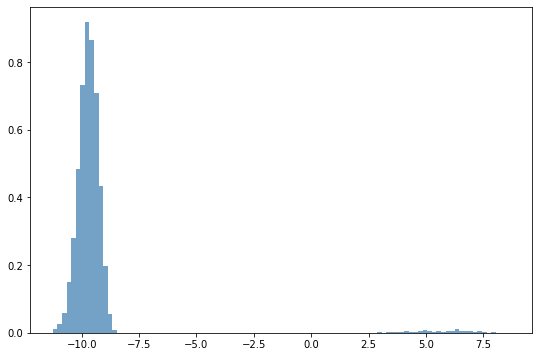

In [25]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.hist(acc_ftr_val_map['y']['mean'], bins=100, density=True, alpha=0.75, color='SteelBlue')
plt.show()

In [10]:
print(calc_feature_domain(acc_ftr_val_map['x']['fft_mean']))

(0.07177968766052467, 0.09166734957927443, 0.1703840072832948, 0.2074900161251042, 0.5216424952665748, 0.7931629919701098)
